<h1 style='text-align: center;'> MTMW14 Project 2 </h1>
<h2 style='text-align: center;'> Student ID: 31827379 </h2>
    
### 1. Introduction

In [1]:
import assignment2 as assign2

### 2. Task A

In [2]:
assign2.wavesDemo.displayGravityWave()

,


Figure 2:

In [3]:
assign2.wavesDemo.displayKelvinWave()

,


Figure 3:

### 3. Task B

### 4. Task C

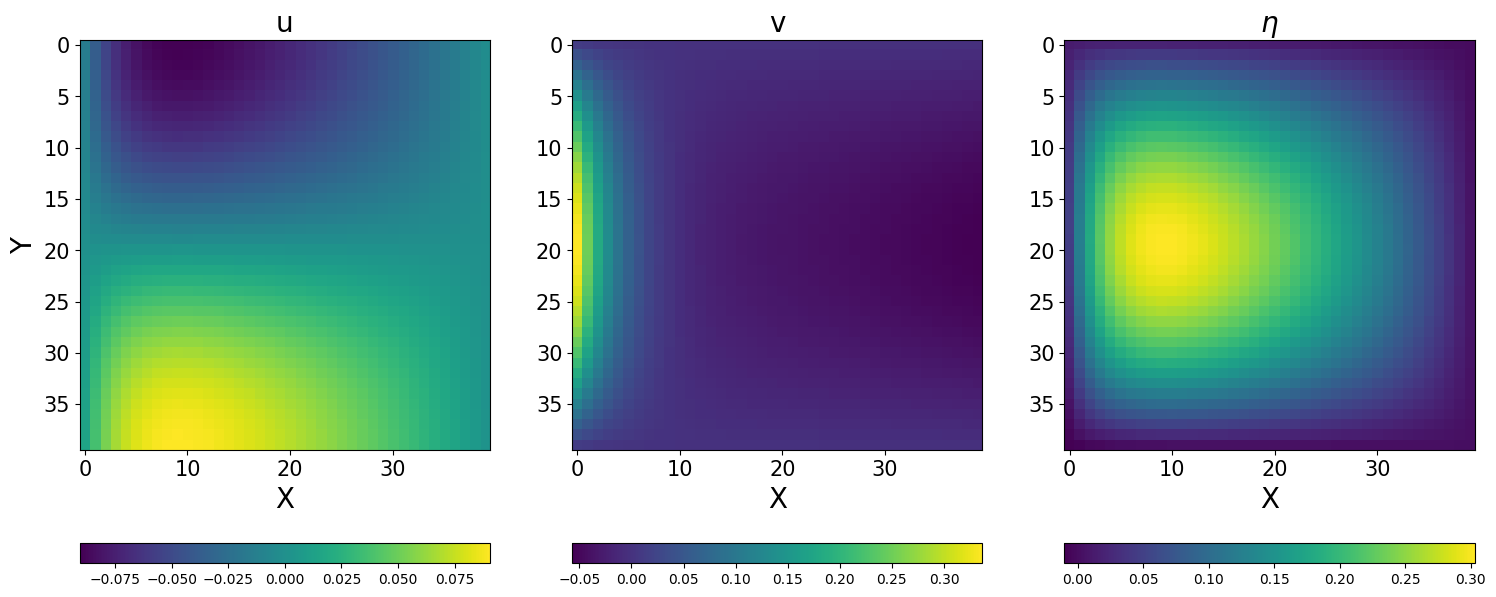

In [5]:
assign2.runTaskC()

Figure 4: 

### 5. Task D

### 6. Task E

### 7. Task F